In [165]:
import seaborn as sns
import pandas as pd
import numpy as np

import re

import pickle

from sentence_transformers import SentenceTransformer

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report

from itertools import cycle
import umap
import umap.plot

---

Merging all .json files together and saving final version

In [2]:
import json
import glob

result = []
for f in glob.glob("/Users/ella.franks/PycharmProjects/redditscrape/data/*.json"):
    with open(f, "rb") as infile:
        result.append(json.load(infile))

In [3]:
with open('2021merged.json', 'w') as f:
    json.dump(result, f)

---

Prepping data - chose to leave the data as it was and do minimal cleaning to maintain information.

In [4]:
def remove(cell):
    cell = re.sub(r'\d+', '', cell)
    if cell == '[removed]' or cell == '[deleted]':
        return np.nan
    else:
        return cell

In [5]:
def create_data(data):
    df = pd.DataFrame(data)
    df.drop_duplicates('body', keep='first', inplace=True)
    df['body'] = df['body'].apply(lambda x: remove(x))
    df.dropna(subset=['body'], inplace=True)
    df['body'] = df['body'].apply(lambda x: x.strip('\n'))
    df = df.reset_index(drop=True)
    return df

---

Fine-tune your own sentence embedding method using S-BERT, so that you get task-specific sentence embedding with an even better understanding of language and context. 
Even though this is not as fast as using avg word embeddings (like GLOVE), it’s one of the fastest transformers and is computationally efficient. This is because words can be processed simultaneously. S-BERT is also better at capturing the true context as its truly bidirectional. 
- S-BERT turns each sentence into a 768 dimension vector, taking the position of the word in the sentence into consideration
- This is so semantically similar sentences are mapped closer together 


In [92]:
model = SentenceTransformer('/Users/ella.franks/Desktop/Projects/Datasets/paraphrase-distilroberta-base-v1')

---

Decided to cut up the data differently, into 3 groups representing extreme positive, extreme negative and neutral values

In [271]:
df = create_data(result)
df = df[['score', 'author', 'body']]

In [272]:
def cut_comment(score):
    if score == 0:
        return 0
    elif score > 10:
        return 1
    elif score < 0:
        return -1

In [273]:
df.score = df.score.apply(cut_comment)
df.dropna(inplace=True)
df = df.reset_index().rename(columns={'index':'old_index'})

In [274]:
df.score.value_counts(normalize=True)

 0.0    0.404435
 1.0    0.369588
-1.0    0.225977
Name: score, dtype: float64

In [276]:
embds = model.encode(df.body)

---

Let's see if we can spot any patterns in the data using umap or tsne

In [278]:
X_embedded = TSNE(random_state=1, n_jobs=-1).fit_transform(np.array(X_test))

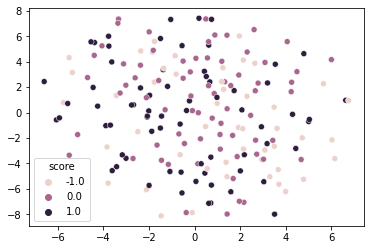

In [279]:
sns.scatterplot(x= X_embedded[:,0], y=X_embedded[:, 1], hue=y_test);

In [283]:
X_umap_embedding = umap.UMAP(n_components=2).fit(np.array(X_test))

<AxesSubplot:>

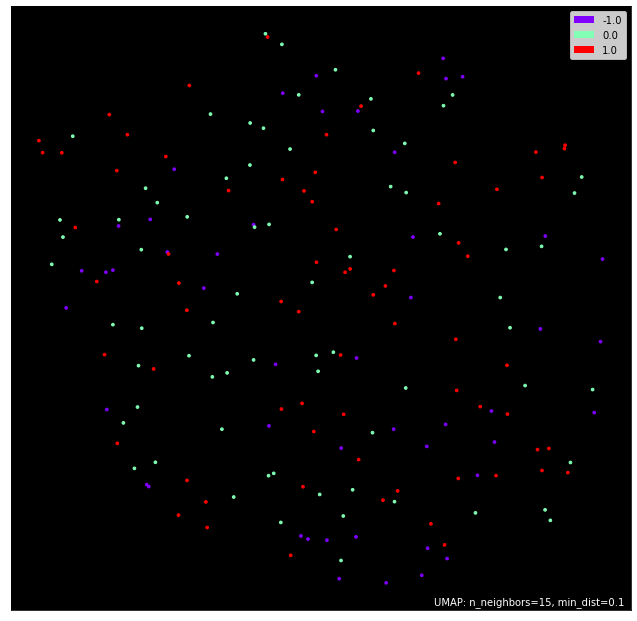

In [284]:
umap.plot.points(X_umap_embedding, labels=y_test,theme='fire')

Doesn't look like there are clear groupings between classes.

---

Using random forest and embeddings

In [304]:
X_train, X_test, y_train, y_test = train_test_split(embds, df.score, test_size=0.2, shuffle=True, random_state=1)

In [305]:
rf = RandomForestClassifier(max_depth=5, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [306]:
confusion_matrix(y_train, rf.predict(X_train))

array([[ 69,  73,  24],
       [  0, 311,   1],
       [  0,  10, 269]])

In [307]:
confusion_matrix(y_test, rf.predict(X_test))

array([[ 0, 38, 10],
       [ 0, 50, 21],
       [ 0, 47, 24]])

In [289]:
print(classification_report(y_test, rf.predict(X_test), labels=[-1,0,1], zero_division=1))

              precision    recall  f1-score   support

          -1       1.00      0.00      0.00        48
           0       0.37      0.70      0.49        71
           1       0.44      0.34      0.38        71

    accuracy                           0.39       190
   macro avg       0.60      0.35      0.29       190
weighted avg       0.55      0.39      0.32       190



Performs badly on the negative and neutral classes. Lets go for an algo thats better at dealing with imbalenced classes. 

---

SVM good at dealing with imbalenced classes

In [290]:
clf = svm.SVC(decision_function_shape='ovo', class_weight='balanced', probability=True, random_state=1)
clf.fit(X_train, y_train)

SVC(class_weight='balanced', decision_function_shape='ovo', probability=True,
    random_state=1)

In [291]:
confusion_matrix(y_train, clf.predict(X_train))

array([[155,   6,   5],
       [  9, 276,  27],
       [  9,  12, 258]])

In [292]:
confusion_matrix(y_test, clf.predict(X_test))

array([[18, 17, 13],
       [19, 33, 19],
       [13, 21, 37]])

In [308]:
clf.score(X_test, y_test)

0.4631578947368421

In [173]:
print(classification_report(y_test, clf.predict(X_test), labels=[-1,0,1], zero_division=1))

              precision    recall  f1-score   support

          -1       0.22      0.34      0.27        35
           0       0.40      0.40      0.40        78
           1       0.73      0.64      0.68       158

    accuracy                           0.53       271
   macro avg       0.45      0.46      0.45       271
weighted avg       0.57      0.53      0.55       271



In [322]:
results = pd.DataFrame({'actual': y_test, 
              'pred':clf.predict(X_test),
              'pred_prob':clf.predict_proba(X_test).max(axis=1)})

results[(results['pred_prob']>0.55)&(results['pred_prob']<0.9)][['actual', 'pred']].all(axis=1).mean()

Important to identify class 1 and -1. Right now, doing well on positive and neutral classes. Should tune this towards the negative class. 

---

Using onevs rest methods to plot ROC curve of all 3 classes.

In [251]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [315]:
y = label_binarize(df.score, classes=[-1, 0, 1])

In [316]:
X_train, X_test, y_train, y_test = train_test_split(embds, y, test_size=0.2, shuffle=True, random_state=1)

In [317]:
classifier = OneVsRestClassifier(svm.SVC(decision_function_shape='ovo', 
                                         class_weight='balanced', 
                                         probability=True, 
                                         random_state=1))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [318]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

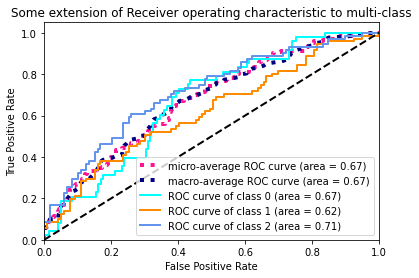

In [319]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 2
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Reassuring that class low and high scoring comments have a higher ROC curve than the neutral class. 

---